# Character Predicting with RNN
---

Codes are writen by simonjisu.
* Simonjisu Blog: https://simonjisu.github.io
* Project Numpy with NN: https://github.com/simonjisu/NUMPYwithNN



## Goal
Writing 'Hello world! Nice to meet you! I love iron-man' using RNN with numpy

|Input||Output|
|:-:|:-:|:-:|
|h|$\rightarrow$|e|
|e|$\rightarrow$|l|
|l|$\rightarrow$|l|
|l|$\rightarrow$|o|
|$\vdots$|$\vdots$|$\vdots$|
|y|$\rightarrow$|o|
|o|$\rightarrow$|u|


## Packages

In [1]:
import os
import sys
dir_path = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(dir_path)

In [2]:
import numpy as np
from common.SimpleRNN import Single_layer_RNN
from common.optimizer import Adam
from common.train_graph import loss_graph
np.random.seed(1234)

## DATA

In [3]:
x = 'hello world! nice to meet you! i love iron-man'

### Encoder

In [4]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

Change our data to one-hot encoding data by single character. 

In [5]:
encoder = chr_coding()
encoder.fit(x)
one_hot_data = encoder.encode(x)

print('data shape:', one_hot_data.shape)  # total 29 datas, 16 unique character

data shape: (46, 19)


## Parameters

In [6]:
NUM_EPOCHS = 3000
INPUT_SIZE = one_hot_data.shape[1]
HIDDEN_SIZE = 30
OUTPUT_SIZE = one_hot_data.shape[1]
SEQ_LEN = one_hot_data.shape[0] - 1
BPTT_TRUNCATE = 5  
# Backpropagation Through Time Truncate: 
# A fixed number of steps to lookback past data in BPTT

## Get Training Datas

In [7]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

## Call RNN module & Optimizer Setting

Basic Settings of **Single_layer_RNN**

* input_size: input layer size
* hidden_size: hidden layer size
* output_size: output layer size
* bptt_truncate: if you want to use it, use backward_truncate method when you doing backward, default=0
* activation_func: if use "tanh", params will initialize as Xavier, use "relu", initialize as He, default="tanh"

In [8]:
# accuracy calculation function
def get_accuracy(x, test_string):
    bool_ = np.array(list(x))[1:] == np.array(list(test_string))[1:]
    return bool_.sum() / len(bool_)

### Using BPTT

When using BPTT, our model is not stable. Sometimes it fits well but mostly it is hard to achive our goal.

In [9]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE)
optim = Adam()

In [10]:
total_loss_list = []
total_acc_list = []
for epoch in range(NUM_EPOCHS):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward
    rnn.backward()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test string
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    
    # get accuracy
    acc = get_accuracy(x, test_string)
    
    if epoch % 100 == 0:
        print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
              .format(epoch, total_loss, acc, test_string))
    elif epoch == (NUM_EPOCHS-1):
        print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
              .format(epoch, total_loss, acc, test_string))

    total_loss_list.append(total_loss)
    total_acc_list.append(acc)

#0, Loss: 3.093564, Acc: 0.044444, Test_string: "hrwlnndeltlnad-drvnaddhnnldhlmwu tvnlaldtlltnh"
#100, Loss: 2.084058, Acc: 0.511111, Test_string: "h llo wrrode ntc wtn m ntl e ntd ltoe intd-man"
#200, Loss: 1.724541, Acc: 0.600000, Test_string: "h llo wrrod!untc !tn mentlymu!tn ltno intn-man"
#300, Loss: 1.383292, Acc: 0.822222, Test_string: "h llo world!untce!tn mentnymu! i love iron-man"
#400, Loss: 1.173376, Acc: 0.822222, Test_string: "h llo world!enice!tnymeetnymu! i leve iron-man"
#500, Loss: 0.984630, Acc: 0.844444, Test_string: "h llo world!wnice!toymeetnymu! i leve iron-man"
#600, Loss: 0.850495, Acc: 0.911111, Test_string: "hello world!wnice!toymeetnyou! i love iron-man"
#700, Loss: 0.747074, Acc: 0.933333, Test_string: "hello world! nice!toimeetnyou! i love iron-man"
#800, Loss: 0.654607, Acc: 0.933333, Test_string: "hello world! nice!toimeetnyou! i love iron-man"
#900, Loss: 0.594941, Acc: 0.933333, Test_string: "hello world! nice!toimeetnyou! i love iron-man"
#1000, Loss:

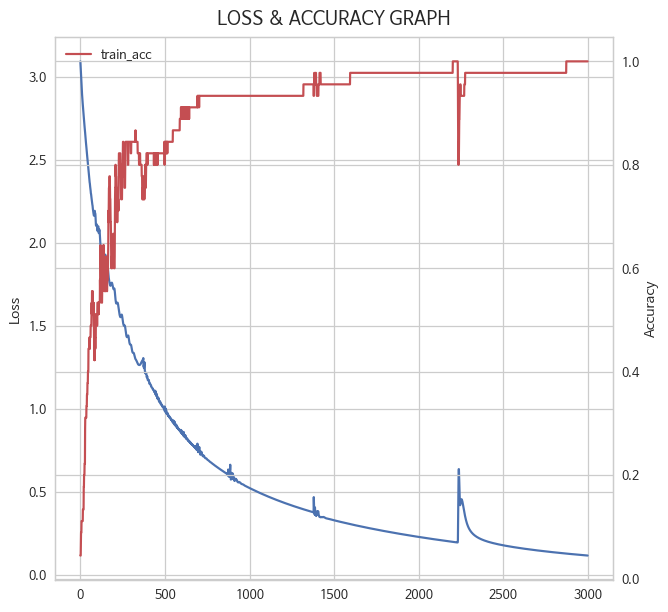

In [11]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using BPTT-Truncate

In [12]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE)
optim = Adam()

In [13]:
total_loss_list = []
total_acc_list = []
for epoch in range(NUM_EPOCHS):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward-truncate
    rnn.backward_truncate()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test string
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    
    # get accuracy
    acc = get_accuracy(x, test_string)
    
    if epoch % 100 == 0:
        print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
              .format(epoch, total_loss, acc, test_string))
    elif epoch == (NUM_EPOCHS-1):
        print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
              .format(epoch, total_loss, acc, test_string))

    total_loss_list.append(total_loss)
    total_acc_list.append(acc)

#0, Loss: 3.001762, Acc: 0.088889, Test_string: "h tnnrryumrtvirtvhrdt!cwtvr-d!vdadtv ti-mrnncw"
#100, Loss: 2.523621, Acc: 0.222222, Test_string: "hetmnnw!mnd!mret!mnd!!aet!mod!!red-vvtlmrnw!me"
#200, Loss: 2.228289, Acc: 0.400000, Test_string: "hel rnw!red!mrncmrnd!maelmreu!rnnlmret!rnn!man"
#300, Loss: 2.018890, Acc: 0.511111, Test_string: "hel rnw!red! nncmrnu!meelmyeu!rnnlmvet!rnnlman"
#400, Loss: 1.833165, Acc: 0.622222, Test_string: "hel nnworld! nncmrtu!meel yeu!rnnlmvet!ren-man"
#500, Loss: 1.667492, Acc: 0.733333, Test_string: "hellonworld! nncmrtu!meet yeu! nnlmvel!ron-man"
#600, Loss: 1.520078, Acc: 0.755556, Test_string: "hellonworld! nncmrtu!meet yeu! nelovel!ron-man"
#700, Loss: 1.389157, Acc: 0.822222, Test_string: "hellonworld! nicmrtu!meet you! neloveliron-man"
#800, Loss: 1.273140, Acc: 0.844444, Test_string: "hello world! nicortu!meet you! neloveliron-man"
#900, Loss: 1.170420, Acc: 0.844444, Test_string: "hello world! nicortu!meet you! neloveliron-man"
#1000, Loss:

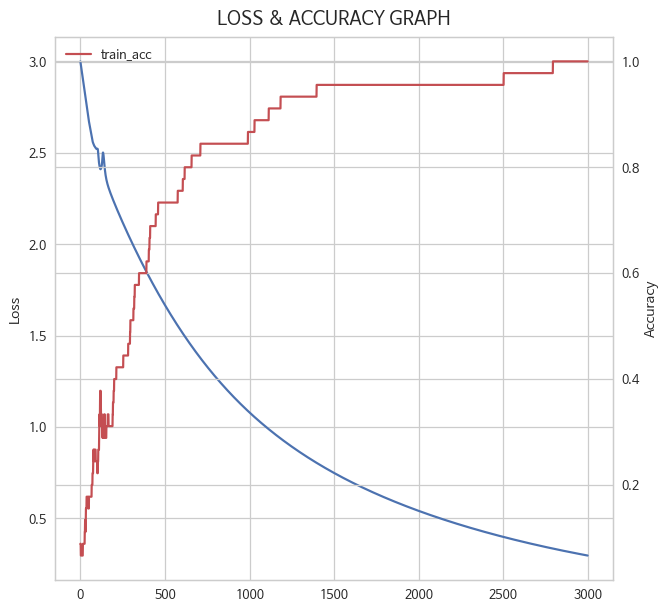

In [14]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using ReLu as activation functions

In [15]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE,
                       activation_func='relu')
optim = Adam()

In [16]:
total_loss_list = []
total_acc_list = []
for epoch in range(NUM_EPOCHS):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward-truncate
    rnn.backward_truncate()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test string
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    
    # get accuracy
    acc = get_accuracy(x, test_string)
    
    if epoch % 100 == 0:
        print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
              .format(epoch, total_loss, acc, test_string))
    elif epoch == (NUM_EPOCHS-1):
        print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
              .format(epoch, total_loss, acc, test_string))

    total_loss_list.append(total_loss)
    total_acc_list.append(acc)

#0, Loss: 10.658776, Acc: 0.066667, Test_string: "hurll!!rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr"
#100, Loss: 6.987955, Acc: 0.177778, Test_string: "huale!!r!- u-! lr-nrnrer--en-rrn l- ernre-- !n"
#200, Loss: 8.861561, Acc: 0.088889, Test_string: "hoalol!rl- uondmaimmnnmoonmnn yonmoonmno mnn y"
#300, Loss: 5.182294, Acc: 0.177778, Test_string: "hoalol!rn- ui!ulrvnun en- nnvairm nornnoeo-man"
#400, Loss: 4.616257, Acc: 0.222222, Test_string: "hellolwrn-uui!ulrvnue  n-ulnvaorm nirlioeo-man"
#500, Loss: 3.952043, Acc: 0.222222, Test_string: "hellolwrn-uui!olrunuruyurulnva!rm nrroiveo-man"
#600, Loss: 3.320726, Acc: 0.288889, Test_string: "hellolwrn-uui olrunnruynrmlnuanrm nrrlivon-man"
#700, Loss: 2.755100, Acc: 0.333333, Test_string: "hello wrn-uni ootunnruynvmniuaoim nrolivon-man"
#800, Loss: 2.300454, Acc: 0.422222, Test_string: "hello wrn-dni !otrnnrmynvmniuaoim nvoliron-man"
#900, Loss: 2.003196, Acc: 0.422222, Test_string: "hello wrn-dni !otrnnrmynvmniuaoim nvoliron-man"
#1000, Loss

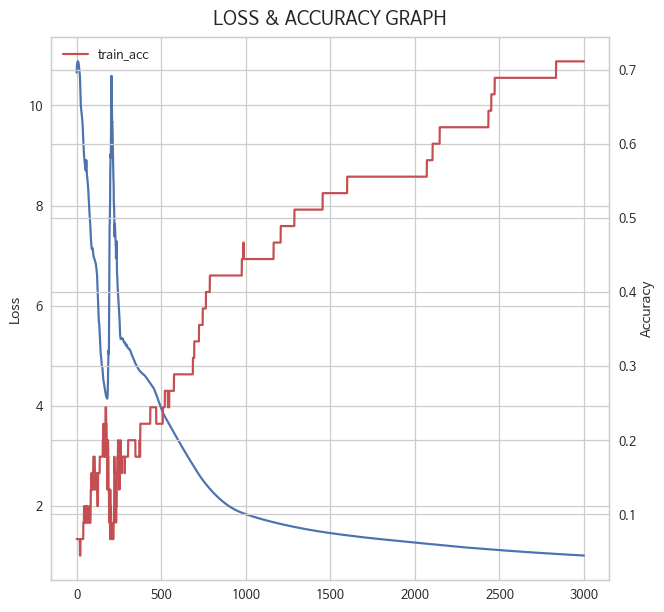

In [17]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

## Check model stablitlity

Run 5 times, each model initialze different weights.

You can see at running # 0, the gradient overflowed (explode) at model "relu + backward_truncate", 

this is because when backpropagate,

$$\begin{aligned}
\dfrac{\partial L}{\partial W_{hh}}  
&= \dfrac{\partial L}{\partial Cost_T} \dfrac{\partial Cost_T}{\partial W_{hh}} + \cdots +
\dfrac{\partial L}{\partial Cost_1} \dfrac{\partial Cost_1}{\partial W_{hh}} \\
&= \dfrac{\partial L}{\partial Cost_T} \dfrac{\partial Cost_T}{\partial y_T} \dfrac{\partial y_T}{\partial h_T} \dfrac{\partial h_T}{\partial h_{T-1}}  \cdots \dfrac{\partial h_2}{\partial h_1} \dfrac{\partial h_1}{\partial W_{hh}} +
\cdots + \dfrac{\partial L}{\partial Cost_1} \dfrac{\partial Cost_1}{\partial y_1} \dfrac{\partial y_1}{\partial h_1} \dfrac{\partial h_1}{\partial W_{hh}} \\
&= \dfrac{\partial L}{\partial Cost_T} \dfrac{\partial Cost_T}{\partial y_T} \dfrac{\partial y_T}{\partial h_T} \prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial h_{T-i}} \dfrac{\partial h_1}{\partial W_{hh}} + \cdots + \dfrac{\partial L}{\partial Cost_1} \dfrac{\partial Cost_1}{\partial y_1} \dfrac{\partial y_1}{\partial h_1} \dfrac{\partial h_1}{\partial W_{hh}}
\end{aligned}$$

Watch careful at this part below.

$$\begin{aligned}
\prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial h_{T-i}}
&= \prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial a_{T-i+1}} \dfrac{\partial a_{T-i+1}}{\partial h_{T-i}} \\
&= \prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial a_{T-i+1}} W_{hh}
\end{aligned}$$

When $W_{hh}$ >1, gradient will be explode, because when you multiplicate by a number larger than 1.

In [18]:
!python3 Character_Predicting_RNN_CV.py

Number of Checking: 5
running # 0 | model1: tanh + backward
running # 0 | model2: tanh + backward_truncate
running # 0 | model3: relu + backward_truncate
/Users/Soo/code/gitproject/NUMPYwithNN/common/optimizer.py:119: RuntimeWarning: overflow encountered in square
  self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])
/Users/Soo/code/gitproject/NUMPYwithNN/common/optimizer.py:119: RuntimeWarning: invalid value encountered in subtract
  self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])
/Users/Soo/code/gitproject/NUMPYwithNN/common/layers.py:13: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
/Users/Soo/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
running # 1 | model1: tanh + backward
running # 1 | model2: tanh + backward_truncate
running # 1 | model3: relu + backward_truncate
running # 2 | model1: tanh + bac